In [1]:
from functools import wraps
import numpy as np
import pandas as pd
from scipy import integrate, optimize, stats
import matplotlib.pyplot as plt

## References

 - Gerardo Chowell, *Fitting dynamic models to epidemic outbreaks withquantified uncertainty: A primer for parameter uncertainty,identifiability, and forecasts*, KeAi Infectious Disease Modelling (2017) 379-398
 - Cécile Viboud, *A generalized-growth model to characterize the early ascendingphase of infectious disease outbreaks*, Elsevier Epidemics (2016) 27-37

### Useful Links

 
 - https://www.sciencedirect.com/science/article/pii/S2468042717300234
 - https://www.sciencedirect.com/science/article/pii/S1755436516000037
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
 - https://stackoverflow.com/questions/60791453/how-can-i-fix-this-typeerror-when-fitting-ode-with-scipy
 
 

In [2]:
t = np.arange(0, 50)

## GRM


The Generalized Richards Model:

$$
\dot{C}(t) = \frac{\mathrm{d}C}{\mathrm{d}t} = r C^p\left[1-\left(\frac{C}{K}\right)^a\right]
$$

Where $C(t)$ is the cumulative number of case, $r \in \mathbb{R}^+$ is the **growth rate** and $p \in (0,1)$ is the **deceleration of growth**, $K \in \mathbb{R}^+$ is the **size of the epidemic** and $a$ is the deviation from the S-shaped dynamic.

In [3]:
def GRM_ODE(t, C, r, p, K, a):
    return r*np.power(C, p)*(1-np.power((C/K), a))

In [4]:
def GRM(t, C, r, p, K, a):
    return integrate.solve_ivp(GRM_ODE, (t[0], t[-1]), [C], t_eval=t, args=(r, p, K, a), rtol=1e-9).y[0]

In [5]:
y2 = GRM(t, 2, 1.15, 0.4, 2550, 0.89)

In [6]:
popt2, pcov2 = optimize.curve_fit(GRM, t, y2, bounds=([0.1, 0.1, 0.1, 50, 0.1], [10, 10, 1, 10000, 10]), gtol=1e-9)
(popt2, pcov2)

(array([2.00e+00, 1.15e+00, 4.00e-01, 2.55e+03, 8.90e-01]),
 array([[ 1.17444395e-27, -3.89362595e-28,  1.41117184e-28,
          6.52087851e-24, -2.29522185e-27],
        [-3.89362595e-28,  1.52716834e-28, -5.87762753e-29,
         -3.11466221e-24,  1.04051003e-27],
        [ 1.41117184e-28, -5.87762753e-29,  2.31798485e-29,
          1.30213828e-24, -4.25127359e-28],
        [ 6.52087851e-24, -3.11466221e-24,  1.30213828e-24,
          8.39837153e-20, -2.59660428e-23],
        [-2.29522185e-27,  1.04051003e-27, -4.25127359e-28,
         -2.59660428e-23,  8.20296824e-27]]))

In [7]:
y2f = GRM(t, *popt2)

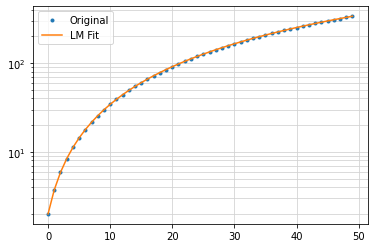

In [8]:
fig, axe = plt.subplots()
axe.semilogy(t, y2, '.', label='Original')
axe.semilogy(t, y2f, label='LM Fit')
axe.legend()
axe.grid(which='both', color='lightgray')

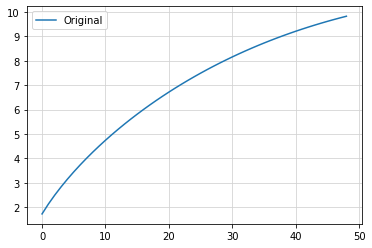

In [9]:
fig, axe = plt.subplots()
axe.plot(t[:-1], np.diff(y2)/np.diff(t), '-', label='Original')
#axe.semilogy(t, y2f, label='LM Fit')
axe.legend()
axe.grid(which='both', color='lightgray')

## Refactoring

### Factory for ODE

We create a factory for ODE adjustment

In [10]:
def ODEFitFactory(f):
    """
    Factory to adjust signature function of the Integrated ODE solved by scipy.integrate.solve_ivp
    to the optimizer provided by scipy.optimize.curve_fit
    The first argument args[0] is the initial condition of the IVP
    The rest of arguments args[1:] are parameters of the Fit
    """
    @wraps(f)
    def inner(t, *args):
        return integrate.solve_ivp(f, (t[0], t[-1]), args[0:], t_eval=t, args=args[1:]).y[0]
    return inner

In [11]:
def ODEFit(ode, x, y, p0=None, bounds=(-np.inf, np.inf)):
    """
    Fit ODE parameters using optimizer provided by scipy.optimize.curve_fit
    """
    odef = ODEFitFactory(ode)
    popt, pcov = optimize.curve_fit(odef, x, y, p0=p0, bounds=bounds)
    return popt, pcov

In [12]:
data = pd.read_json("https://epistat.sciensano.be/Data/COVID19BE_CASES_AGESEX.json")

In [13]:
data.columns

Index(['DATE', 'PROVINCE', 'REGION', 'AGEGROUP', 'SEX', 'CASES'], dtype='object')

In [14]:
data["DATE"] = pd.to_datetime(data["DATE"])

In [15]:
tso = data.groupby("DATE")["CASES"].sum().to_frame()

In [16]:
from scipy import signal

In [17]:
ts = tso.rolling(7).mean()
#ts = signal.savgol_filter(tso["CASES"].values, 9, 3)

In [18]:
tk = "2021-12-21"

<AxesSubplot:xlabel='DATE'>

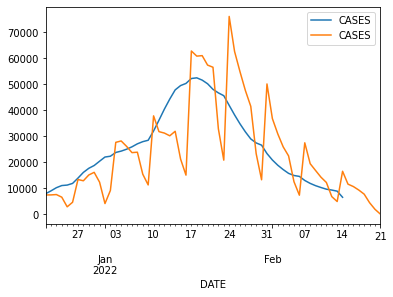

In [19]:
axe = ts[ts.index >= tk].shift(-7).plot()
tso[ts.index >= tk].plot(ax=axe)

In [20]:
cts = tso[tso.index >= tk].cumsum()
tp = (cts.index - pd.Timestamp(tk)) // pd.Timedelta('1d')
cts.index = tp
C = cts["CASES"].values

In [21]:
popt2, pcov2 = optimize.curve_fit(GRM, tp, C, p0=(2e4, 1.1, 0.8, 1.5e6, 1),
                                  bounds=([1, 0.1, 0.1, 50, 0.1], [1e7, 10, 1, 1e7, 10]),
                                  gtol=1e-9, max_nfev=10000)
(popt2, pcov2)

(array([2.19121403e+04, 1.32911051e+00, 7.97534595e-01, 1.50050635e+06,
        1.99619308e+00]),
 array([[ 2.11909404e+07, -4.69308695e+03,  2.85967561e+02,
          1.27527957e+07, -1.35686760e+03],
        [-4.69308695e+03,  1.23548964e+00, -7.62299132e-02,
         -4.91647103e+03,  4.12153604e-01],
        [ 2.85967561e+02, -7.62299132e-02,  4.70750979e-03,
          3.11789466e+02, -2.56900369e-02],
        [ 1.27527957e+07, -4.91647103e+03,  3.11789466e+02,
          8.50334574e+07, -2.45236295e+03],
        [-1.35686760e+03,  4.12153604e-01, -2.56900369e-02,
         -2.45236295e+03,  1.56599160e-01]]))

In [22]:
n = np.arange(100)
c = GRM(tp, *popt2)
cex = GRM(n, *popt2)

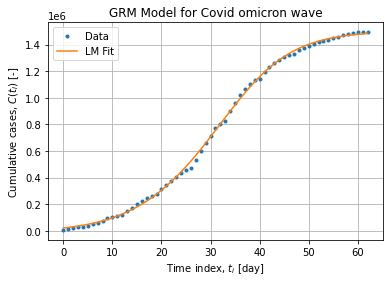

In [23]:
fig, axe = plt.subplots()
axe.plot(tp, C, ".", label="Data")
axe.plot(tp, c, label="LM Fit")
#axe.plot(n, cex, label="LM Fit")
axe.legend()
axe.set_title("GRM Model for Covid omicron wave")
axe.set_xlabel("Time index, $t_i$ [day]")
axe.set_ylabel("Cumulative cases, $C(t_i)$ [-]")
axe.grid()

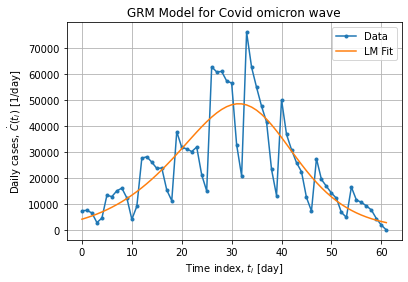

In [25]:
fig, axe = plt.subplots()
axe.plot(tp[:-1], np.diff(C), ".-", label="Data")
axe.plot(tp[:-1], np.diff(c), label="LM Fit")
#axe.plot(n[:-1], np.diff(cex), label="LM Fit")
axe.legend()
axe.set_title("GRM Model for Covid omicron wave")
axe.set_xlabel("Time index, $t_i$ [day]")
axe.set_ylabel("Daily cases, $\dot{C}(t_i)$ [1/day]")
axe.grid()